In [31]:
from bs4 import BeautifulSoup
import urllib.request
import requests
from urllib.parse import quote
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px

import plotly.graph_objs as go
import plotly.figure_factory as ff

In [33]:
train = pd.read_csv('../data/train_777개.csv', index_col=0)
train.head(3)

,Title,Post URL,Post,Post length,Keyword(내돈내산),Sponsered word,Post Count,Date,Review Count,Image Count,Link Count,label
0,효과본 사람이 추천하는 주름개선화장품,https://blog.naver.com/mgcho3/223223137751,관리 전제가 늙어간다는 생각을 안 해봤는데체력도 달라지고 피부도 점점 달라지는 모습...,2559,1,0,399,20231041310,NaN,13,0,0
1,비타민화장품 깨끗한 피부로,https://blog.naver.com/lovejungcy/223185240342,비타민화장품 깨끗한 피부로나이가 확실히 들어갈수록 점점 수분감도많이 줄어들기 시작을...,2671,0,1,761,20238171100,10.0,15,0,1
2,군대 px 화장품 내돈내산 진정템 추천,https://blog.naver.com/sesank/223196415814,잇님들 안녕하쎄우 ~~제가 저번에 동생 군대갔다 했는데시간이 벌써 그렇게 된곤지.....,3094,1,0,119,20238291103,10.0,20,0,0


# 1. Data preprocessing


### 1-1. 데이터 요약 및 Feature 특성 파악

#### Feature Type

**Qualitative(categorical)**
* Nominal
    * Title
    * Post URL
    * Post
    * Date
    * keyword(내돈내산) - binary
    * sponsered word - binary
    
**Quantitative(numerical)**
* Discrete
    * Review Count(float64)
    * Post count
    * Image Count
    * Link Count
* Continuous 
    * Post length

#### Label 

* nominal - binary
    * label(광고 : 1, 비광고:0) 

In [34]:
print('데이터 크기 : ', train.shape)
print('\n train 데이터 정보')
print(train.info())

데이터 크기 :  (777, 12)

 train 데이터 정보
<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 776
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           777 non-null    object 
 1   Post URL        777 non-null    object 
 2   Post            777 non-null    object 
 3   Post length     777 non-null    int64  
 4   Keyword(내돈내산)   777 non-null    int64  
 5   Sponsered word  777 non-null    int64  
 6   Post Count      777 non-null    int64  
 7   Date            777 non-null    int64  
 8   Review Count    734 non-null    float64
 9   Image Count     777 non-null    int64  
 10  Link Count      777 non-null    int64  
 11  label           777 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 78.9+ KB
None


### 1-2. 결측치 확인 및 중복값 확인

#### null 값 처리 : 0으로 채우기 (fillna)

단어 개수에서 null 값이 나오는 경우는 다음과 같이 작성자가 댓글 창을 열어두지 않은 경우이다.

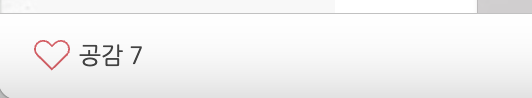

단어 개수가 0인 경우는 실제로 댓글이 없는 경우이다. 

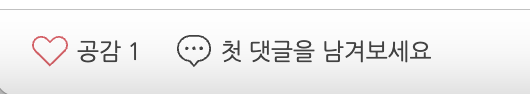

따라서 null값은 0으로 처리해주었다.

In [35]:
# Missing value 처리
print( 'null 값 확인 : \n', train.isnull().sum())

null 값 확인 : 
 Title              0
Post URL           0
Post               0
Post length        0
Keyword(내돈내산)      0
Sponsered word     0
Post Count         0
Date               0
Review Count      43
Image Count        0
Link Count         0
label              0
dtype: int64


In [36]:
# fillna(0) null value 
train = train.fillna(0)
train.head(3)

,Title,Post URL,Post,Post length,Keyword(내돈내산),Sponsered word,Post Count,Date,Review Count,Image Count,Link Count,label
0,효과본 사람이 추천하는 주름개선화장품,https://blog.naver.com/mgcho3/223223137751,관리 전제가 늙어간다는 생각을 안 해봤는데체력도 달라지고 피부도 점점 달라지는 모습...,2559,1,0,399,20231041310,0.0,13,0,0
1,비타민화장품 깨끗한 피부로,https://blog.naver.com/lovejungcy/223185240342,비타민화장품 깨끗한 피부로나이가 확실히 들어갈수록 점점 수분감도많이 줄어들기 시작을...,2671,0,1,761,20238171100,10.0,15,0,1
2,군대 px 화장품 내돈내산 진정템 추천,https://blog.naver.com/sesank/223196415814,잇님들 안녕하쎄우 ~~제가 저번에 동생 군대갔다 했는데시간이 벌써 그렇게 된곤지.....,3094,1,0,119,20238291103,10.0,20,0,0


### 1-3. Data type 인코딩

## 1-3. 레이블 분포 확인

In [37]:
train['label'].value_counts()

1    494
0    283
Name: label, dtype: int64

## 1-4. Feature 분포확인 (이상치 전처리)

### 1-4-1. Post length

Post length 의 경우 5000 값을 넘어가는 이상치가 확인되었다. 

이상치 데이터가 모델학습에 반영되면 weight 가 급격하게 커지거나 작아질 수 있다.

만약 길이가 길수록 광고일 확률이 높아진다고 하자

Post length의 경우 평균값이 약 2500정도이지만 이상치가 포함되었을 때 모델이 4000이상의 값에 대해서도 크지 않다고 판단해버릴 수 있다. 

그렇게 되면 모델이 광고,비광고 여부를 판단하는데 이러한 영향이 크게 작용할 수 있기 때문에 이상치를 제거해주었다.

IQR 방법을 통해 outlier 를 정의하고 이를 상한값으로 대체해주었다. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9f3050eeb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9f3051f490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9f3050ebe0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9f3051fa30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9f3051ffd0>],
 'means': [<matplotlib.lines.Line2D at 0x7f9f3051fd00>]}

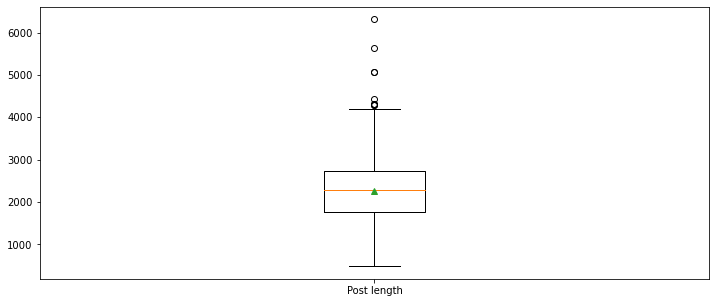

In [38]:
# boxplot
plt.figure(figsize=(12,5))
plt.boxplot(train['Post length'], labels=['Post length'], showmeans=True)

하한값 :  289.5
상한값 :  4205.5
이상치 : 67     4308
214    5077
224    4427
429    6312
484    5636
504    4292
577    4308
639    5077
756    4292
Name: Post length, dtype: int64
이상치의 개수: 9


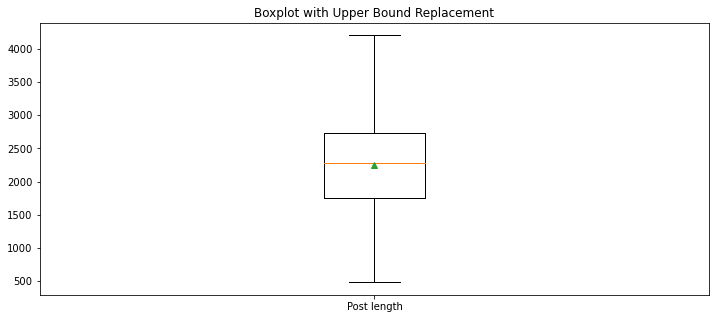

In [39]:
# IQR 이상치
Q1 = train['Post length'].quantile(0.25)
Q3 = train['Post length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('하한값 : ', lower_bound)
print('상한값 : ', upper_bound)

# 이상치 찾기
outliers = train[(train['Post length'] < lower_bound) | (train['Post length'] > upper_bound)]
print('이상치 :' , outliers['Post length'])

# 이상치 개수 출력
num_outliers = len(outliers)
print(f"이상치의 개수: {num_outliers}")

# 이상치를 상한 값으로 대체
train['Post length'] = np.clip(train['Post length'], lower_bound, upper_bound)

# Boxplot 그리기
plt.figure(figsize=(12, 5))
plt.boxplot(train['Post length'], labels=['Post length'], showmeans=True)
plt.title('Boxplot with Upper Bound Replacement')
plt.show()

In [19]:
train.shape[0]

777

이상치 대체 후 광고, 비광고 데이터 통계치를 비교해 본 결과, 광고성 데이터가 평균이 더 크게나오는 것을 확인할 수 있다.

In [40]:
#광고, 비광고 평균 차이
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]


display(ad_train['Post length'].describe(), 
       nad_train['Post length'].describe())

count     494.000000
mean     2318.459514
std       703.257785
min       611.000000
25%      1815.000000
50%      2339.000000
75%      2767.000000
max      4205.500000
Name: Post length, dtype: float64

count     283.000000
mean     2141.355124
std       743.707108
min       479.000000
25%      1649.000000
50%      2098.000000
75%      2628.500000
max      4205.500000
Name: Post length, dtype: float64

In [41]:
from scipy import stats

# 두 집단의 데이터 추출
data_ad = ad_train['Post length']
data_nad = nad_train['Post length']

# 등분산을 가정한 t-검정
t_statistic, p_value = stats.ttest_ind(data_ad, data_nad)

# t-검정 결과 출력
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# p-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 집단 간의 차이는 유의미하다.")
else:
    print("두 집단 간의 차이는 유의미하지 않다.")
    
#  t검정을 진행한 결과 p-value는 유의수준 0.05 보다 작기때문에 95%확률로 집단간의 차이가 유의미하다. 

t-statistic: 3.3075470994466265
p-value: 0.0009845621598121527
두 집단 간의 차이는 유의미하다.


([<matplotlib.axis.XTick at 0x7f9f79109f70>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

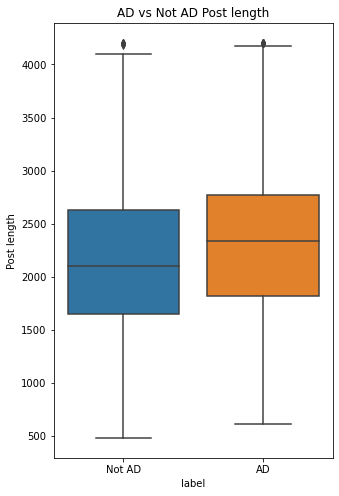

In [42]:
# boxplot 시각화 
plt.figure(figsize=(5, 8))
plt.title('AD vs Not AD Post length')
sns.boxplot(data=train, x = 'label', y = 'Post length')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

### 1-4-2.  Post count

quantitative(numerical), discrete데이터인 post count 에 대해서도 분포를 확인해본다. 

이상치가 발견되면 앞과 같은 방법으로 제거해준다.

크롤링 도중 무한대의 값이 출력되어 잘못된 값이 나온 것으로 확인된다. 

총 4개 정도의 말도 안되는 이상치 값이 나와 이를 제거해주었다. 

따라서 lower,upperbound 값을 조정하여 말도안되는? 값을 제거해주었다. 그리고 boxplot을 다시 시각화하여 보았다.

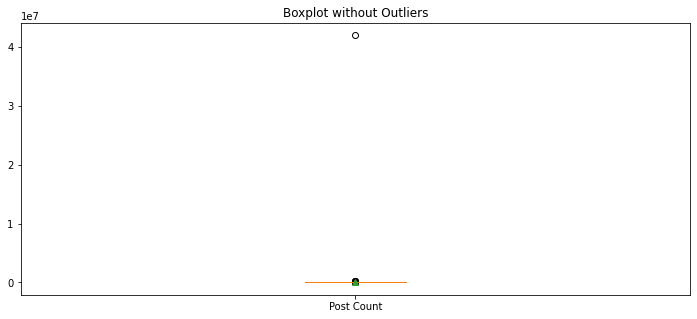

In [43]:
# 이상한 이상치가 너무 많음
plt.figure(figsize=(12, 5))
plt.boxplot(train['Post Count'], labels=['Post Count'], showmeans=True)
plt.title('Boxplot without Outliers')
plt.show()

해당 이상치 값은 말도 안되는 수치임을 확인할 수 있다. IQR 방법으로 이상치를 제거한다.

하한값 :  -542.0
상한값 :  1122.0
이상치 최소 값 : 1160
이상치 최대 값 : 42023110
이상치의 개수: 75


([<matplotlib.axis.XTick at 0x7f9f39aca520>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

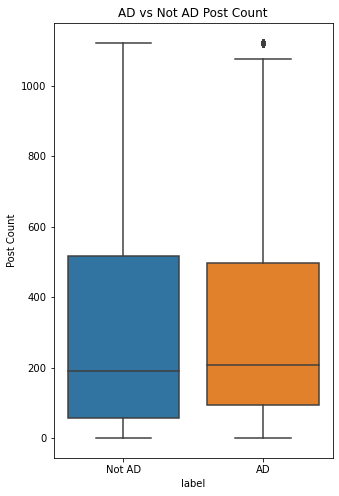

In [44]:
# IQR 이상치 제거
Q1 = train['Post Count'].quantile(0.25)
Q3 = train['Post Count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('하한값 : ', lower_bound)
print('상한값 : ', upper_bound)

# 이상치 찾기
outliers = train[(train['Post Count'] < lower_bound) | (train['Post Count'] > upper_bound)]

print('이상치 최소 값 :', outliers['Post Count'].min())
print('이상치 최대 값 :', outliers['Post Count'].max())


# 이상치 개수 출력
num_outliers = len(outliers)
print(f"이상치의 개수: {num_outliers}")

# 이상치를 상한 값으로 대체
train['Post Count'] = np.clip(train['Post Count'], lower_bound, upper_bound)

plt.figure(figsize=(5, 8))
plt.title('AD vs Not AD Post Count')
sns.boxplot(data=train, x = 'label', y = 'Post Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

광고인 경우에 좀 Post 가 더 많은 것을 확인할 수 있다. 하지만 크게 차이는 나지 않는다. 

In [45]:
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]
display(ad_train['Post Count'].describe(), nad_train['Post Count'].describe())

count     494.000000
mean      337.801619
std       333.812954
min         0.000000
25%        93.250000
50%       207.000000
75%       498.000000
max      1122.000000
Name: Post Count, dtype: float64

count     283.000000
mean      358.996466
std       381.450261
min         0.000000
25%        56.000000
50%       191.000000
75%       517.500000
max      1122.000000
Name: Post Count, dtype: float64

In [46]:
from scipy import stats

# 두 집단의 데이터 추출
data_ad = ad_train['Post Count']
data_nad = nad_train['Post Count']

# 등분산을 가정한 t-검정
t_statistic, p_value = stats.ttest_ind(data_ad, data_nad)

# t-검정 결과 출력
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# p-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 집단 간의 차이는 유의미하다.")
else:
    print("두 집단 간의 차이는 유의미하지 않다.")

t-statistic: -0.8079131689361261
p-value: 0.419388475921574
두 집단 간의 차이는 유의미하지 않다.


In [47]:
train.shape[0]

777

### 1-4-2. Review Count

Not AD 쪽에서 이상치가 있는 것을 확인할 수 있다. 

([<matplotlib.axis.XTick at 0x7f8b89e6fe80>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

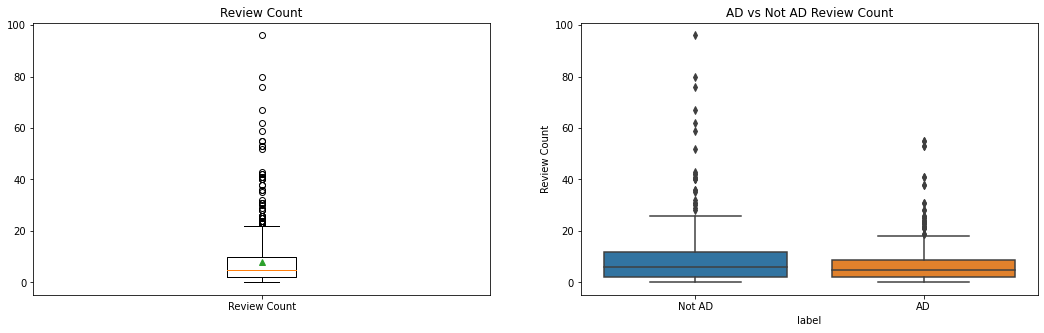

In [21]:
#boxplot
plt.figure(figsize=(18, 5))

# 전체 분포에 대한 boxplot
plt.subplot(1, 2, 1)
plt.boxplot(train['Review Count'], labels=['Review Count'], showmeans=True)
plt.title('Review Count')

# 광고/비광고 별 boxplot
plt.subplot(1, 2, 2)
plt.title('AD vs Not AD Review Count')
sns.boxplot(data=train, x='label', y='Review Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

이상치의 개수: 0


([<matplotlib.axis.XTick at 0x7f8b98931fd0>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

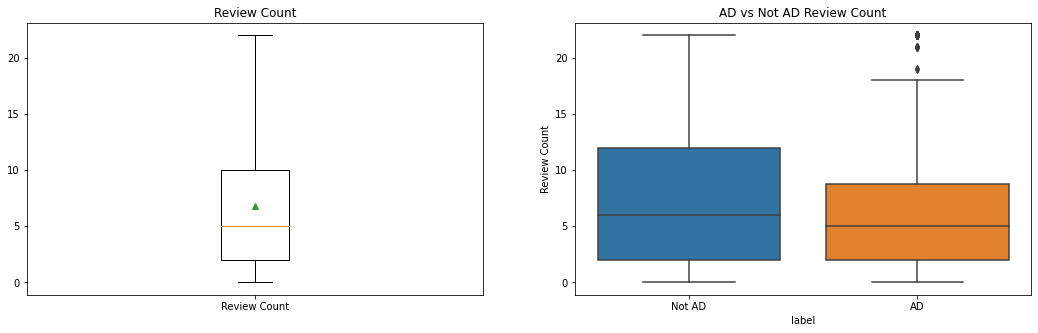

In [23]:
# IQR 이상치
Q1 = train['Review Count'].quantile(0.25)
Q3 = train['Review Count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 찾기
outliers = train[(train['Review Count'] < lower_bound) | (train['Review Count'] > upper_bound)]

# 이상치 개수 출력
num_outliers = len(outliers)
print(f"이상치의 개수: {num_outliers}")

# 이상치를 상한 값으로 대체
train['Review Count'] = np.clip(train['Review Count'], lower_bound, upper_bound)

#boxplot
plt.figure(figsize=(18, 5))

# 전체 분포에 대한 boxplot
plt.subplot(1, 2, 1)
plt.boxplot(train['Review Count'], labels=['Review Count'], showmeans=True)
plt.title('Review Count')

# 광고/비광고 별 boxplot
plt.subplot(1, 2, 2)
plt.title('AD vs Not AD Review Count')
sns.boxplot(data=train, x='label', y='Review Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

비광고에서 댓글수가 더 많은 것을 확인할 수 있다. 하지만 큰 차이는 발견되지 않는다.

In [24]:
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]
display(ad_train['Review Count'].describe(), nad_train['Review Count'].describe())

count    494.000000
mean       6.105263
std        6.052262
min        0.000000
25%        2.000000
50%        5.000000
75%        8.750000
max       22.000000
Name: Review Count, dtype: float64

count    283.000000
mean       8.031802
std        7.388585
min        0.000000
25%        2.000000
50%        6.000000
75%       12.000000
max       22.000000
Name: Review Count, dtype: float64

In [25]:
from scipy import stats

# 두 집단의 데이터 추출
data_ad = ad_train['Review Count']
data_nad = nad_train['Review Count']

# 등분산을 가정한 t-검정
t_statistic, p_value = stats.ttest_ind(data_ad, data_nad)

# t-검정 결과 출력
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# p-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 집단 간의 차이는 유의미하다.")
else:
    print("두 집단 간의 차이는 유의미하지 않다.")
    
# 유의미하다. 

t-statistic: -3.9332879074574763
p-value: 9.130477228437476e-05
두 집단 간의 차이는 유의미하다.


In [22]:
train.shape[0]

777

### 1-4-4. Image Count

([<matplotlib.axis.XTick at 0x7f9f3159f7f0>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

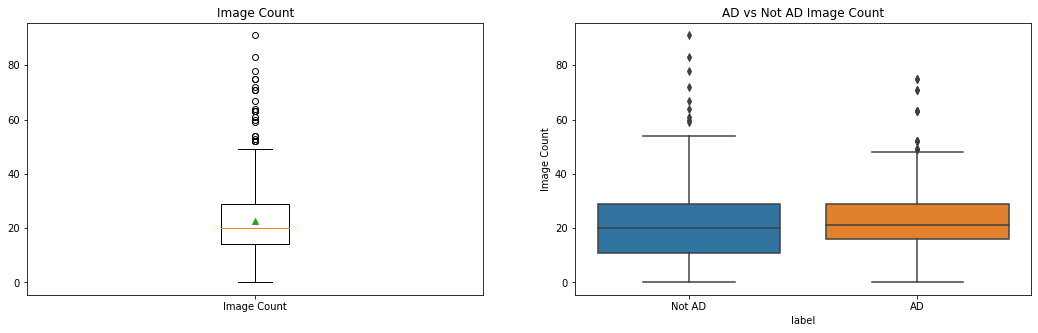

In [48]:
#boxplot
plt.figure(figsize=(18, 5))

# 전체 분포에 대한 boxplot
plt.subplot(1, 2, 1)
plt.boxplot(train['Image Count'], labels=['Image Count'], showmeans=True)
plt.title('Image Count')

# 광고/비광고 별 boxplot
plt.subplot(1, 2, 2)
plt.title('AD vs Not AD Image Count')
sns.boxplot(data=train, x='label', y='Image Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

하한값 :  -8.5
상한값 :  51.5
이상치 최소 값 : 52
이상치 최대 값 : 91
이상치의 개수: 24


([<matplotlib.axis.XTick at 0x7f9f39b14790>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

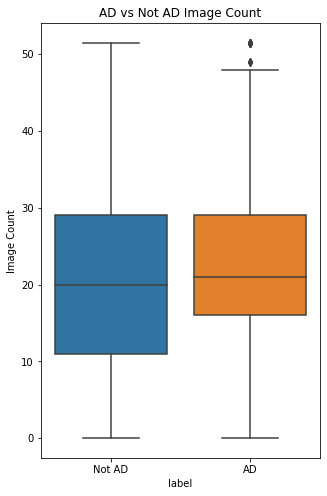

In [49]:
# IQR 이상치 제거
Q1 = train['Image Count'].quantile(0.25)
Q3 = train['Image Count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('하한값 : ', lower_bound)
print('상한값 : ', upper_bound)

# 이상치 찾기
outliers = train[(train['Image Count'] < lower_bound) | (train['Image Count'] > upper_bound)]

print('이상치 최소 값 :', outliers['Image Count'].min())
print('이상치 최대 값 :', outliers['Image Count'].max())

# 이상치 개수 출력
num_outliers = len(outliers)
print(f"이상치의 개수: {num_outliers}")

# 이상치를 상한 값으로 대체
train['Image Count'] = np.clip(train['Image Count'], lower_bound, upper_bound)

# 이상치 제거 후 boxplot 
plt.figure(figsize=(5, 8))
plt.title('AD vs Not AD Image Count')
sns.boxplot(data=train, x = 'label', y = 'Image Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

평균의 차이가 약간 나는 것을 확인할 수 있다. 광고 리뷰가 이미지 개수가 좀 더 많다.

In [50]:
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]
display(ad_train['Image Count'].describe(), nad_train['Image Count'].describe())

count    494.000000
mean      23.161943
std       10.724661
min        0.000000
25%       16.000000
50%       21.000000
75%       29.000000
max       51.500000
Name: Image Count, dtype: float64

count    283.000000
mean      20.918728
std       12.479221
min        0.000000
25%       11.000000
50%       20.000000
75%       29.000000
max       51.500000
Name: Image Count, dtype: float64

In [51]:
from scipy import stats

# 두 집단의 데이터 추출
data_ad = ad_train['Image Count']
data_nad = nad_train['Image Count']

# 등분산을 가정한 t-검정
t_statistic, p_value = stats.ttest_ind(data_ad, data_nad)

# t-검정 결과 출력
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# p-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 집단 간의 차이는 유의미하다.")
else:
    print("두 집단 간의 차이는 유의미하지 않다.")
    
# 유의미하다. 

t-statistic: 2.6407389914767694
p-value: 0.00843909033243817
두 집단 간의 차이는 유의미하다.


### 1-4-5. Link Count

([<matplotlib.axis.XTick at 0x7f9f4ccfc0d0>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

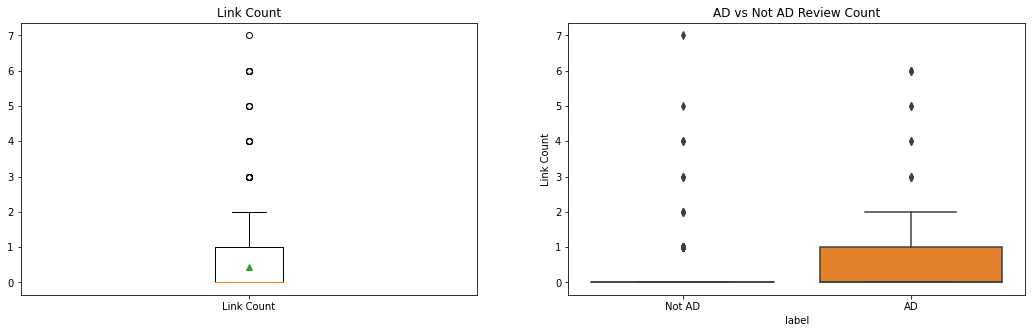

In [53]:
#boxplot
plt.figure(figsize=(18, 5))

# 전체 분포에 대한 boxplot
plt.subplot(1, 2, 1)
plt.boxplot(train['Link Count'], labels=['Link Count'], showmeans=True)
plt.title('Link Count')

# 광고/비광고 별 boxplot
plt.subplot(1, 2, 2)
plt.title('AD vs Not AD Review Count')
sns.boxplot(data=train, x='label', y='Link Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

하한값 :  -1.5
상한값 :  2.5
이상치 최소 값 : 3
이상치 최대 값 : 7
이상치의 개수: 20


([<matplotlib.axis.XTick at 0x7f9f314f8400>,
 [Text(0, 0, 'Not AD'), Text(1, 0, 'AD')])

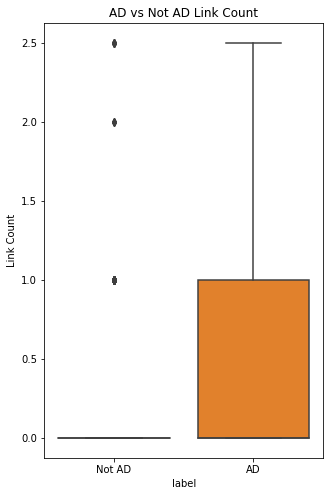

In [54]:
# IQR 이상치 제거
Q1 = train['Link Count'].quantile(0.25)
Q3 = train['Link Count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('하한값 : ', lower_bound)
print('상한값 : ', upper_bound)

# 이상치 찾기
outliers = train[(train['Link Count'] < lower_bound) | (train['Link Count'] > upper_bound)]

print('이상치 최소 값 :', outliers['Link Count'].min())
print('이상치 최대 값 :', outliers['Link Count'].max())

# 이상치 개수 출력
num_outliers = len(outliers)
print(f"이상치의 개수: {num_outliers}")

# 이상치를 상한 값으로 대체
train['Link Count'] = np.clip(train['Link Count'], lower_bound, upper_bound)

# 이상치 대체 후 boxplot 
plt.figure(figsize=(5, 8))
plt.title('AD vs Not AD Link Count')
sns.boxplot(data=train, x = 'label', y = 'Link Count')
plt.xticks(ticks=[0, 1], labels=['Not AD', 'AD'])

링크의 개수는 정말 큰 차이가 없는 것을 확인할 수 있다.

In [55]:
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]
display(ad_train['Link Count'].describe(), nad_train['Link Count'].describe())

count    494.000000
mean       0.445344
std        0.660420
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.500000
Name: Link Count, dtype: float64

count    283.000000
mean       0.303887
std        0.595091
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.500000
Name: Link Count, dtype: float64

In [56]:
from scipy import stats

# 두 집단의 데이터 추출
data_ad = ad_train['Link Count']
data_nad = nad_train['Link Count']

# 등분산을 가정한 t-검정
t_statistic, p_value = stats.ttest_ind(data_ad, data_nad)

# t-검정 결과 출력
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# p-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 집단 간의 차이는 유의미하다.")
else:
    print("두 집단 간의 차이는 유의미하지 않다.")
    
# 유의미하다. 

t-statistic: 2.9767520242686
p-value: 0.003003894536880572
두 집단 간의 차이는 유의미하다.


### '내돈내산 키워드 여부'

In [16]:
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]
display(ad_train['Keyword(내돈내산)'].describe(), nad_train['Keyword(내돈내산)'].describe())

count    494.000000
mean       0.008097
std        0.089710
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Keyword(내돈내산), dtype: float64

count    283.000000
mean       0.236749
std        0.425840
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Keyword(내돈내산), dtype: float64

In [17]:
from scipy.stats import chi2_contingency

# Crosstab 생성
cross_tab = pd.crosstab(train['Keyword(내돈내산)'], train['label'])

# 카이제곱 검정 수행
chi2, p_value, _, _ = chi2_contingency(cross_tab)

# 검정 결과 출력
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

# P-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 카테고리 간의 차이는 유의미하다.")
else:
    print("두 카테고리 간의 차이는 유의미하지 않다.")

Chi-square statistic: 110.56051988516985
P-value: 7.385589325454606e-26
두 카테고리 간의 차이는 유의미하다.


### '협찬 문구' 여부

In [18]:
ad_train = train.loc[train['label']==1]
nad_train = train.loc[train['label']==0]
display(ad_train['Sponsered word'].describe(), nad_train['Sponsered word'].describe())

count    494.000000
mean       0.495951
std        0.500490
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Sponsered word, dtype: float64

count    283.000000
mean       0.014134
std        0.118254
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Sponsered word, dtype: float64

In [19]:
from scipy.stats import chi2_contingency

# Crosstab 생성
cross_tab = pd.crosstab(train['Sponsered word'], train['label'])

# 카이제곱 검정 수행
chi2, p_value, _, _ = chi2_contingency(cross_tab)

# 검정 결과 출력
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

# P-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 카테고리 간의 차이는 유의미하다.")
else:
    print("두 카테고리 간의 차이는 유의미하지 않다.")

Chi-square statistic: 189.60135969400682
P-value: 3.884597962744419e-43
두 카테고리 간의 차이는 유의미하다.


In [263]:
train.to_csv('../data/train_777개_preprocessing.csv')

## 2. Feature Engineering

### 2-1. Date 칼럼의 처리

네이버 블로그 노출 정책으로 인해 데이터를 수집한 시점을 기준으로 가장 최근에 작성한 포스트는 과거 시점에 작성된 포스트 대비 노출 빈도가 높아지므로 상단에 위치될 확률이 높다.
이에 작성 날짜는 포스트의 노출과 밀접한 관련이 있기에 블로그 운영자의 목적에 따라 포스트 작성 횟수가 빈번한 경우 가장 최근 작성 날짜의 포스트가
수집될 것으로 추정할 수 있다. 

따라서 상업성을 목적으로 한다면, 최근 게시글이 더 많을 수도 있다고 생각하여 최근 10일을 기준으로 하여 날짜 데이터를 binary type 형태로 바꾸어본다. 

데이터 수집 날짜는 20231115일을 기준으로하여 7일전의 값이라면 1, 아니라면 0의 값을 부여한다.

따라서 날짜는 20231110-20231113 값 범위에 있는 값이라면 1, 아니라면 0의 값을 부여한다.

In [34]:
train['Date'] = train['Date'].astype(str).str[:8]
# 20231110' ~ '20231115'를 가지는 데이터 선택
filtered_data = train[train['Date'].str.startswith(('2023116','2023117','2023118', '2023119')) |
                      ((train['Date'] >= '20231113') & (train['Date'] <= '20231115'))]

filtered_data

,Title,Post URL,Post,Post length,Keyword(내돈내산),Sponsered word,Post Count,Date,Review Count,Image Count,Link Count,label
203,세부자유여행 3박5일 상세 후기,https://blog.naver.com/parangusl_/223256108852,세부자유여행 3박5일 상세 후기공유해요. 제가 선택한 투어는 3박일정의 호캉스 투...,2750.0,0,1,43.0,20231160,4.0,28.0,0.0,1
204,12월 태국 치앙마이 해외여행 준비 추천 일정,https://blog.naver.com/bpkarijju/223259292307,"가족, 친구와 함께 혹은 혼자 떠나도 좋은 해외여행 장소는 태국이다. 취향에 따라 ...",2752.0,0,1,100.0,20231181,8.0,20.0,0.0,1
205,필리핀 세부 여행 3박 5일 투어 일정 12월 1월 날씨,https://blog.naver.com/pinkyluv83/223257971834,막탄 체험 다이빙안녕하세요.해외여행 블로거 Kimi입니다.​한국에서 4시간 30분 ...,3262.0,0,1,30.0,20231171,22.0,40.0,1.0,1
209,10월 단풍 여행일기 한 달 꽉 채웠던 일정,https://blog.naver.com/mee1202/223262815066,"10월 여행일기 주말, 주중 한 달 꽉 채웠던 날들 안녕하세요. 쥬제이맘이에요. ...",2324.0,0,0,706.0,20231113,22.0,44.0,0.0,0
213,강릉역 렌트카 투루카로 떠나는 편안한 강릉여행,https://blog.naver.com/daisy1505/223258885406,지난 강릉여행에서 여행 계획을 세우며 고심한 것이 대중교통을 이용하여 다닐 것인지 ...,2206.0,0,0,15.0,20231181,12.0,26.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,회기역 맛집 경희대 근처 파스타 맛있는 굿갓,https://blog.naver.com/damie0307/223264873762,"안녕하세요날씨가 갑자기 너무 추워졌네요ㅠㅠ모두들 감기 조심하시고, 오늘은 회기역 맛...",1911.0,0,0,330.0,20231114,1.0,19.0,0.0,1
732,경희대 맛집 회기역 맛집 경양카츠 경희대점,https://blog.naver.com/euna2018/223259451028,"​​경양카츠는 가로수길점, 연남점등 많은 핫플레이스에 자리 잡고 있는 맛집이죠!그 ...",1879.0,0,0,544.0,20231182,1.0,17.0,0.0,1
734,경희대 맛집] 카이스트 주변에 위치한 가성비 좋은 초밥 맛집...,https://blog.naver.com/stellar_63/223258024836,육초연서울특별시 동대문구 회기로13길 24 1층 경희대 맛집 육초연서울특별시 동대문...,1217.0,0,0,382.0,20231189,0.0,28.0,0.0,1
757,"식물성단백질보충제 추천, 뉴베스트 뉴제스트피 프로틴 쉐이크",https://blog.naver.com/11ansgallry/223264515854,식물성단백질보충제 추천 뉴베스트 뉴제스트피 프로틴 쉐이크안녕하세요 제제와앨리스 입니...,1561.0,0,0,1038.0,20231114,3.0,19.0,1.0,1


In [28]:
filtered_data['label'].value_counts()

1    74
0    42
Name: label, dtype: int64

filtered_data 의 분포를 확인해보면 일주일전의 블로그들은 광고인 데이터가 훨씬 많은 것을 확인할 수 있다. 

이제 해당 date값을 이진 데이터로 변환한다.

In [35]:
train['Posted A week ago'] = 0
train.loc[train['Date'].isin(filtered_data['Date']), 'Posted A week ago'] = 1
train.head(3)

,Title,Post URL,Post,Post length,Keyword(내돈내산),Sponsered word,Post Count,Date,Review Count,Image Count,Link Count,label,Posted A week ago
0,효과본 사람이 추천하는 주름개선화장품,https://blog.naver.com/mgcho3/223223137751,관리 전제가 늙어간다는 생각을 안 해봤는데체력도 달라지고 피부도 점점 달라지는 모습...,2559.0,1,0,399.0,20231041,0.0,13.0,0.0,0,0
1,비타민화장품 깨끗한 피부로,https://blog.naver.com/lovejungcy/223185240342,비타민화장품 깨끗한 피부로나이가 확실히 들어갈수록 점점 수분감도많이 줄어들기 시작을...,2671.0,0,1,761.0,20238171,10.0,15.0,0.0,1,0
2,군대 px 화장품 내돈내산 진정템 추천,https://blog.naver.com/sesank/223196415814,잇님들 안녕하쎄우 ~~제가 저번에 동생 군대갔다 했는데시간이 벌써 그렇게 된곤지.....,3094.0,1,0,119.0,20238291,10.0,20.0,0.0,0,0


분포를 확인해보면 AD 가 지난 일주일 동안의 게시글이 더 많은 것을 확인할 수 있다.

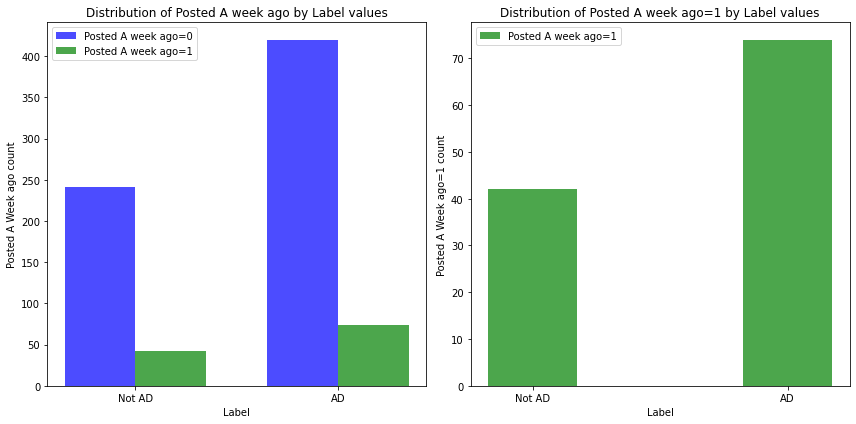

In [45]:
counts = pd.crosstab(train['label'], train['Posted A week ago'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


# 첫 번째 subplot: 'Posted A week ago' 값에 대한 막대그래프
width = 0.35
axes[0].bar(counts.index - width/2, counts[0], width, label='Posted A week ago=0', color='blue', alpha=0.7)
axes[0].bar(counts.index + width/2, counts[1], width, label='Posted A week ago=1', color='green', alpha=0.7)
axes[0].set_title('Distribution of Posted A week ago by Label values')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Posted A Week ago count')
axes[0].set_xticks(counts.index)
axes[0].set_xticklabels(['Not AD', 'AD'])
axes[0].legend()

# 두 번째 subplot: 'Posted A week ago=1' 값에 대한 막대그래프
axes[1].bar(counts.index, counts[1], width, label='Posted A week ago=1', color='green', alpha=0.7)
axes[1].set_title('Distribution of Posted A week ago=1 by Label values')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Posted A Week ago=1 count')
axes[1].set_xticks(counts.index)
axes[1].set_xticklabels(['Not AD', 'AD'])
axes[1].legend()

plt.tight_layout()
plt.show()

In [38]:
from scipy.stats import chi2_contingency

# Crosstab 생성
cross_tab = pd.crosstab(train['Posted A week ago'], train['label'])

# 카이제곱 검정 수행
chi2, p_value, _, _ = chi2_contingency(cross_tab)

# 검정 결과 출력
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

# P-value를 기준으로 유의수준(일반적으로 0.05)과 비교하여 유의미한지 판단
if p_value < 0.05:
    print("두 카테고리 간의 차이는 유의미하다.")
else:
    print("두 카테고리 간의 차이는 유의미하지 않다.")

Chi-square statistic: 0.0
P-value: 1.0
두 카테고리 간의 차이는 유의미하지 않다.


### 4. Standard scaler

이상치를 제거해준 뒤 스케일링 작업을 진행한다.

In [36]:
# 스케일링 처리
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
train = std.fit_transform(train)

# EDA

이제까지 전처리된 데이터를 활용하여 실제 레이블 값과의 상관관계를 분석한다.

히트맵을 통해 확인한 결과, keyword, sponseredword 는 큰 상관관계를 가지는 것이 확인된다. 

Post A week ago의 경우 거의 상관관계가 나타나지 않고 있다. 

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning:

Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from current font.

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning:

Glyph 46024 (\N{HANGUL SYLLABLE DON}) missing from current font.

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning:

Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.



<AxesSubplot:>

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from current font.

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 46024 (\N{HANGUL SYLLABLE DON}) missing from current font.

/Users/jominseo/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.



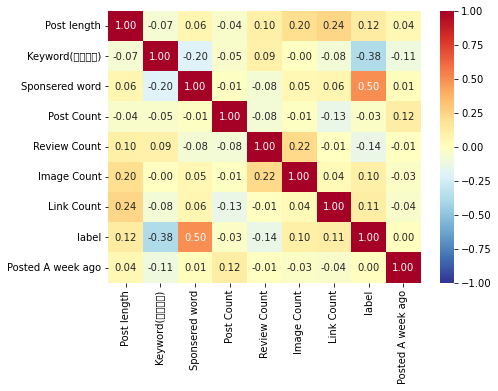

In [55]:
corr = train.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr,cmap = 'RdYlBu_r', vmin = -1, vmax = 1, annot=True, fmt='.2f')